In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [20]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [21]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [22]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [23]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [24]:
# Here we use third piece (80%train-20%val) to train model three and test on first piece
column_indices = {name: i for i, name in enumerate(third_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]
test_df3 = first_piece

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3
test_df3 = (test_df3 - train_mean3) / train_std3

train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)
test_seq3, test_labels3 = create_sequences(test_df3.values, 12)
# Convert to PyTorch tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3)  # (batch, output_dim)
test_seq_tensor3 = torch.FloatTensor(test_seq3)  # (batch, seq_length, input_dim)
test_labels_tensor3 = torch.FloatTensor(test_labels3)  # (batch, output_dim)

In [25]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

In [26]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)

In [27]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion(y_pred, train_label_tensor3)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9447710514068604, Val Loss: 1.3014558553695679
Epoch 10, Train Loss: 0.17561323940753937, Val Loss: 0.19790786504745483
Epoch 20, Train Loss: 0.06370019912719727, Val Loss: 0.03805425390601158
Epoch 30, Train Loss: 0.03309622034430504, Val Loss: 0.011485235765576363
Epoch 40, Train Loss: 0.026155909523367882, Val Loss: 0.011528069153428078
Epoch 50, Train Loss: 0.020476937294006348, Val Loss: 0.012684866786003113
Epoch 60, Train Loss: 0.018443429842591286, Val Loss: 0.013662748038768768
Epoch 70, Train Loss: 0.017322324216365814, Val Loss: 0.012889338657259941
Epoch 80, Train Loss: 0.016761189326643944, Val Loss: 0.012241493910551071
Epoch 90, Train Loss: 0.016419926658272743, Val Loss: 0.012138433754444122


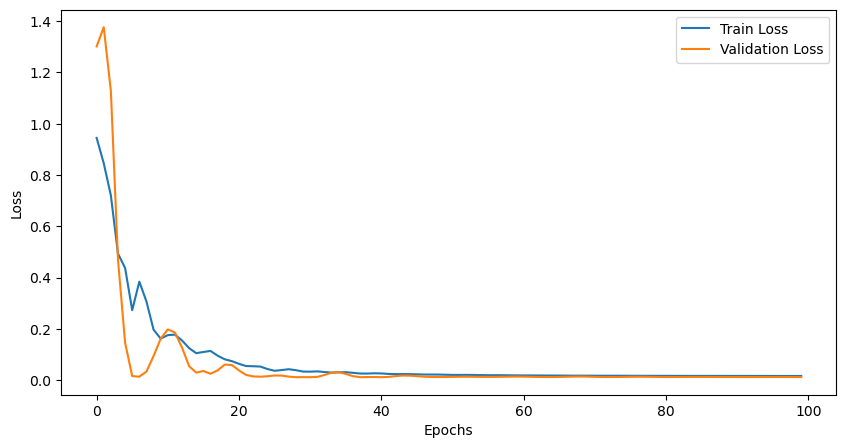

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


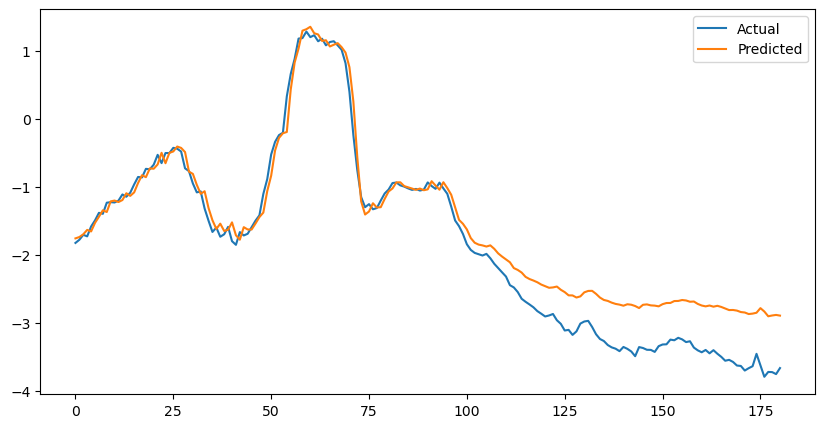

In [29]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [30]:
print(f'MAE: {criterion(test_labels_tensor3, y_pred_test)}')

MAE: 0.16409321129322052


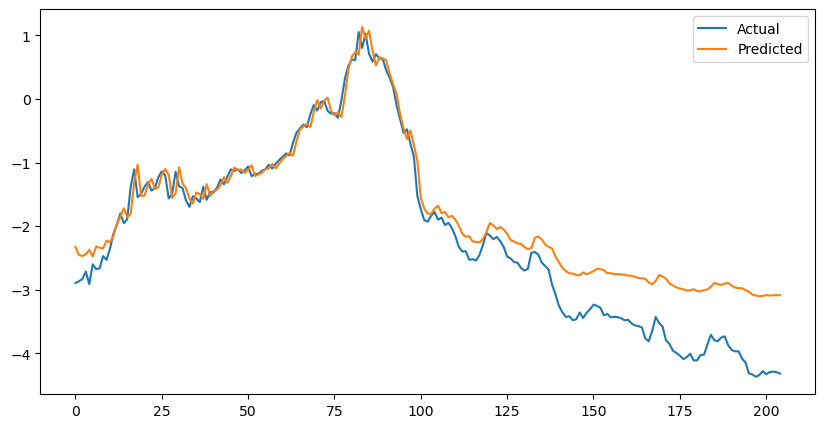

In [31]:
test_df2 = second_piece


test_df2 = (test_df2 - train_mean3) / train_std3

test_seq2, test_labels2 = create_sequences(test_df2.values, 12)
# Convert to PyTorch tensors
test_seq_tensor2 = torch.FloatTensor(test_seq2)  # (batch, seq_length, input_dim)
test_labels_tensor2 = torch.FloatTensor(test_labels2)  # (batch, output_dim)


model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [32]:
print(f'MAE: {criterion(test_labels_tensor2, y_pred_test)}')

MAE: 0.29867711663246155


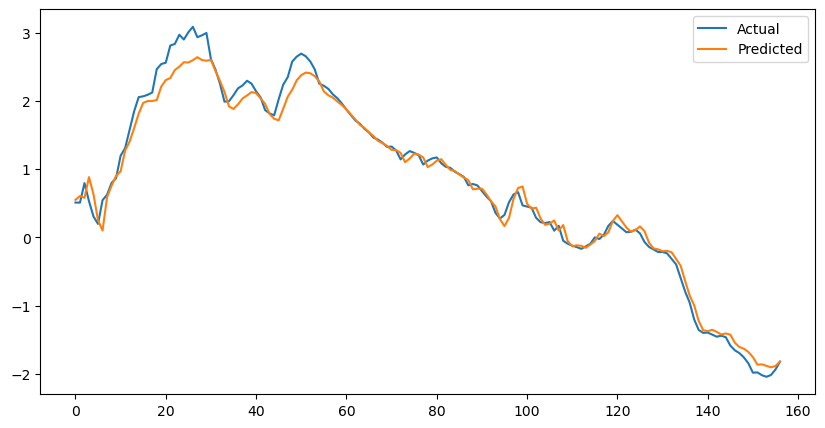

In [34]:
test_df4 = fourth_piece


test_df4 = (test_df4 - train_mean3) / train_std3

test_seq4, test_labels4 = create_sequences(test_df4.values, 12)
# Convert to PyTorch tensors
test_seq_tensor4 = torch.FloatTensor(test_seq4)  # (batch, seq_length, input_dim)
test_labels_tensor4 = torch.FloatTensor(test_labels4)  # (batch, output_dim)


model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [35]:
print(f'MAE: {criterion(test_labels_tensor4, y_pred_test)}')

MAE: 0.028792448341846466
